# Deep Reinforcement Learning - Assignment 3
## Training and Comparing Meta-Learning and Transfer-Learning using an Actor-Critic agent

This notebook implements, trains, and evaluates Policy Gradient agents.

### Assignment Structure:
- **Section 1**: One step Actor-Critic for Different Tasks
- **Section 2**: Fine-Tuning a Trained Model for Different Tasks:
    - CartPole-v1
    - Acrobot-v1
    - MountainCarContinuous-v0 (discretized via adapters)   
- **Section 3**: Transfer Learning with Progressive Networks
---

In [1]:
# # Connect notebook to GitHub repo, for GoogleColab

# import os
# if not os.path.exists('TransferLearning'):
#     !git clone https://github.com/shaharoded/TransferLearning.git
# os.chdir('TransferLearning')
# !git pull origin main

In [2]:
# Setup: Add project root to Python path
import os
import sys
from __future__ import annotations

# Get the notebook's directory
notebook_dir = os.path.abspath('')
project_root = notebook_dir  # Since notebook is in project root

# Add to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

Project root: /dt/shabtaia/GenAI-Sec-for-SMEs/haller/DRL/TransferLearning


In [3]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from dataclasses import asdict

# PyTorch
import torch

# Gymnasium
import gymnasium as gym

# Disable PyTorch 2.0+ compilation features that might cause issues
torch._dynamo.config.suppress_errors = True
import torch._dynamo
torch._dynamo.disable()

# Force complete module reload
modules_to_remove = [key for key in list(sys.modules.keys()) 
                    if 'agent' in key.lower() or 'src' in key or 'utils' in key or 'ffnn' in key]
for module in modules_to_remove:
    del sys.modules[module]

# Import custom modules
import src.adapters
import src.ffnn
import src.agent
import src.train
import src.training_utils
import src.wrappers

from src.adapters import get_default_env_specs
from src.agent import AgentConfig, ActorCriticAgent
from src.train import train_actor_critic, finetune_actor_critic
from src.training_utils import plot_training_curves_grid, plot_diagnostics_grid, summarize_run, compare_runs
from src.wrappers import MountainCarRewardShaping

# Reload to get latest changes (run this cell again after editing source files)
importlib.reload(src.adapters)
importlib.reload(src.ffnn)
importlib.reload(src.agent)
importlib.reload(src.train)
importlib.reload(src.training_utils)
importlib.reload(src.wrappers)

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- SEED SETTING ---
SEED = 42
def set_seeds(seed=SEED, env=None):
    """Set seeds for reproducibility across numpy, random, torch, and gym."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    if env is not None:
        env.action_space.seed(seed)
        env.reset(seed=seed)
        print(f"✓ Environment seeded with {seed}")

set_seeds()
print(f"✓ Global seeds set to {SEED}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Modules reloaded successfully")

✓ Global seeds set to 42
✓ PyTorch version: 2.9.0+cu128
✓ Modules reloaded successfully


In [4]:
STATE_DIM = 6
ACTION_DIM = 5

# Moving average window for convergence
MA_WINDOW = 100

specs = get_default_env_specs(state_dim=STATE_DIM, action_dim=ACTION_DIM)

# Quick sanity check: masks and dims
for name, spec in specs.items():
    print(name, "obs_dim=", spec.obs_dim, "state_dim=", spec.state_dim, "action_dim=", spec.action_dim, "valid_actions=", spec.valid_action_indices)

cartpole obs_dim= 4 state_dim= 6 action_dim= 5 valid_actions= (0, 1)
acrobot obs_dim= 6 state_dim= 6 action_dim= 5 valid_actions= (0, 1, 2)
mountaincar obs_dim= 2 state_dim= 6 action_dim= 5 valid_actions= (0, 1, 2, 3, 4)


## Part 1: Training Individual Networks 

In this part, using the same architectures (+ adapters), we'll train seperate networks per task

In [5]:
# Shared Agent architecture
# Agent learning config (If needed: override per env)
BASE_AGENT_CFG = AgentConfig(
    gamma=0.99,
    hidden_sizes=[128],
    actor_lr=5e-4,
    critic_lr=1e-3,
    entropy_coef=0.01,
    grad_clip_norm=None,
)

# Task configs (target_reward is only used for plotting purposes)
TASKS = {
    "cartpole": {
        "gym_id": "CartPole-v1",
        "target_reward": 475,
        "target_success_rate": 0.95,
        "success_criterion": {"type": "length", "threshold": 500, "comparison": "greater_equal"}, # Solved task at reward == 500
        "max_episodes": 2000,
        "max_steps": 500,
        "agent_cfg": BASE_AGENT_CFG,
    },
    "acrobot": {
        "gym_id": "Acrobot-v1",
        "target_reward": -100,
        "target_success_rate": 0.95,
        "success_criterion": {"type": "reward", "threshold": -100, "comparison": "greater_equal"}, # Solved task at reward == -100
        "max_episodes": 4000,
        "max_steps": 500,
        "agent_cfg": BASE_AGENT_CFG,
    },
    "mountaincar": {
        "gym_id": "MountainCarContinuous-v0",
        "target_reward": 150, # Adapted to reward shaping
        "target_success_rate": 0.95,
        "success_criterion": {"type": "length", "threshold": 999, "comparison": "less"}, # If reached the flag within 999 steps -> Success
        "max_episodes": 10000,
        "max_steps": 1000,
        "agent_cfg": AgentConfig(**{**asdict(BASE_AGENT_CFG), "entropy_coef": 0.10})  # increase exploration to exploit successful strategy
    }
}

In [6]:
histories = {}

for env_name, cfg in TASKS.items():
    print("\n" + "="*80)
    print(f"Training {env_name} ({cfg['gym_id']})")
    print("="*80)

    # 1) Create env
    env = gym.make(cfg["gym_id"])
    
    # Apply reward shaping wrapper for MountainCar
    if env_name == "mountaincar":
        env = MountainCarRewardShaping(env, position_weight=10.0, velocity_weight=1.0)
        print("✓ Reward shaping applied for MountainCar")
    
    env.reset(seed=SEED)
    env.action_space.seed(SEED)

    # 2) Create agent
    agent = ActorCriticAgent(
        env_spec=specs[env_name],
        config=cfg["agent_cfg"],
        seed=SEED,
    )

    # 3) Train agent
    histories[env_name] = train_actor_critic(
        env=env,
        agent=agent,
        max_episodes=cfg["max_episodes"],
        max_steps_per_episode=cfg["max_steps"],
        ma_window=MA_WINDOW,
        target_success_rate=cfg.get("target_success_rate"),
        success_criterion=cfg.get("success_criterion"),
        verbose=True,
        print_every=50,
        reset_seed_base=SEED,
    )

    env.close()

    print("Summary:", summarize_run(histories[env_name]))


Training cartpole (CartPole-v1)
✓ Agent device: cuda
[cartpole] ep=   1 MA_R(100)=   20.00 MA_len(100)=  20.0 success_rate=0.00%
[cartpole] ep=  50 MA_R(100)=   18.38 MA_len(100)=  18.4 success_rate=0.00%
[cartpole] ep= 100 MA_R(100)=   19.72 MA_len(100)=  19.7 success_rate=0.00%
[cartpole] ep= 150 MA_R(100)=   24.39 MA_len(100)=  24.4 success_rate=0.00%
[cartpole] ep= 200 MA_R(100)=   38.16 MA_len(100)=  38.2 success_rate=0.00%
[cartpole] ep= 250 MA_R(100)=   51.84 MA_len(100)=  51.8 success_rate=0.00%
[cartpole] ep= 300 MA_R(100)=   69.05 MA_len(100)=  69.0 success_rate=0.00%
[cartpole] ep= 350 MA_R(100)=  105.54 MA_len(100)= 105.5 success_rate=0.00%
[cartpole] ep= 400 MA_R(100)=  176.18 MA_len(100)= 176.2 success_rate=4.00%
[cartpole] ep= 450 MA_R(100)=  275.26 MA_len(100)= 275.3 success_rate=23.00%
[cartpole] ep= 500 MA_R(100)=  196.15 MA_len(100)= 196.2 success_rate=21.00%
[cartpole] ep= 550 MA_R(100)=   82.11 MA_len(100)=  82.1 success_rate=2.00%
[cartpole] ep= 600 MA_R(100)=  1

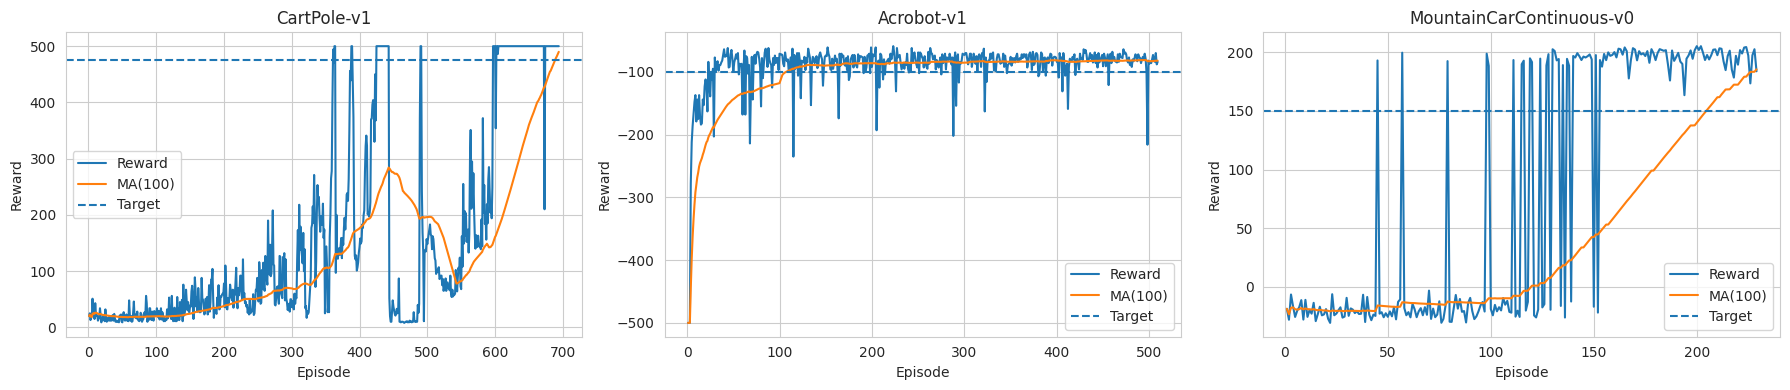

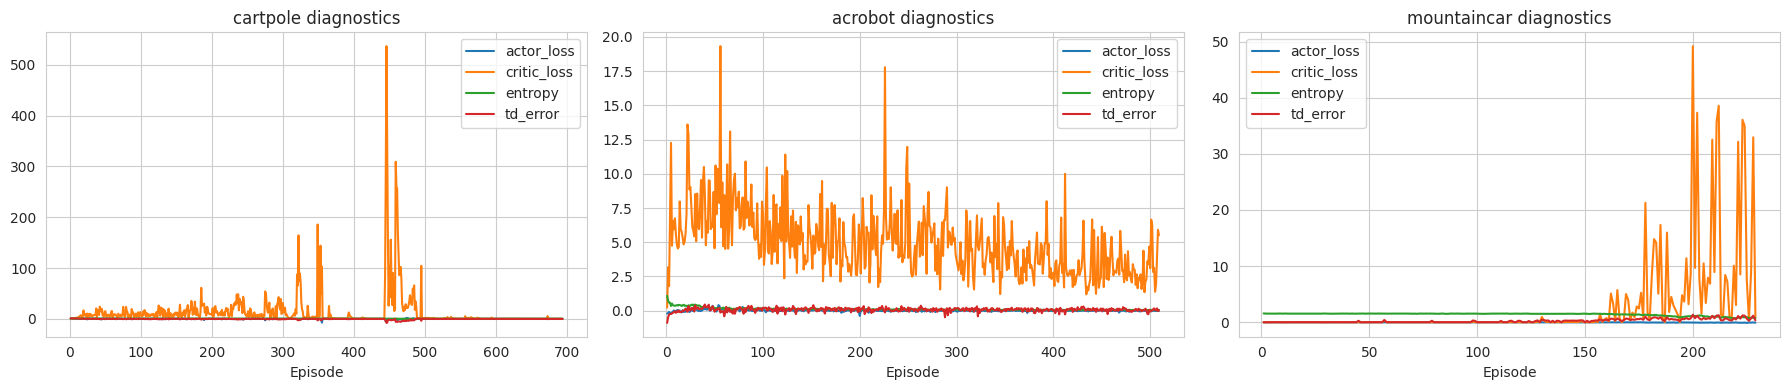

In [7]:
# Analyze
order = ["cartpole", "acrobot", "mountaincar"]

thresholds = {k: TASKS[k]["target_reward"] for k in order}
titles = {k: TASKS[k]["gym_id"] for k in order}

plot_training_curves_grid(
    histories,
    order=order,
    titles=titles,
    thresholds=thresholds,
    grid_shape=(1, 3),
    figsize=(18, 4),
)

plot_diagnostics_grid(
    histories,
    order=order,
    grid_shape=(1, 3),
    figsize=(18, 4),
)

## Part 2: Fine-Tune an Existing Model

In this part well load trained models from part 1 and will fine tune them to other tasks, by re-initiating their final layer, hoping to reduce converage time on the same target.

In [8]:
SEED = 42
STATE_DIM = 6
ACTION_DIM = 5

specs = get_default_env_specs(state_dim=STATE_DIM, action_dim=ACTION_DIM)

CKPTS = {
    "cartpole": "models/CartPole-v1.pth",
    "acrobot": "models/Acrobot-v1.pth",
    "mountaincar": "models/MountainCarContinuous-v0.pth",
}

In [9]:
FT_EXPERIMENTS = [
    {
        "name": "acrobot_to_cartpole",
        "source_ckpt": CKPTS["acrobot"],
        "target_key": "cartpole",
        "gym_id": "CartPole-v1",
        "max_episodes": 2000,
        "max_steps": 500,
        "ma_window": 100,
        "target_success_rate": 0.95,
        "success_criterion": {"type": "length", "threshold": 500, "comparison": "greater_equal"},
        "agent_cfg": BASE_AGENT_CFG,
        "save_path": "models/ft_acrobot_to_cartpole.pth",
    },
    {
        "name": "cartpole_to_mountaincar",
        "source_ckpt": CKPTS["cartpole"],
        "target_key": "mountaincar",
        "gym_id": "MountainCarContinuous-v0",
        "max_episodes": 5000,
        "max_steps": 999,
        "ma_window": 100,
        "target_success_rate": 0.95,
        "success_criterion": {"type": "length", "threshold": 999, "comparison": "less"},
        "agent_cfg": AgentConfig(**{**asdict(BASE_AGENT_CFG), "entropy_coef": 0.10}),  # increase exploration to exploit successful strategy
        "save_path": "models/ft_cartpole_to_mountaincar.pth",
    },
]

### Re-Initiating both Actor's and Critic's Output

In [10]:
finetune_histories = {}
finetune_summaries = {}

for exp in FT_EXPERIMENTS:
    print("\n" + "="*90)
    print(f"Fine-tuning: {exp['name']}  |  target={exp['gym_id']}")
    print("="*90)

    # Create target env in notebook (clean ownership)
    env = gym.make(exp["gym_id"])
    env.reset(seed=SEED)
    env.action_space.seed(SEED)

    if exp["gym_id"] == "MountainCarContinuous-v0":
        env = MountainCarRewardShaping(env, position_weight=10.0, velocity_weight=1.0)
        print("✓ Reward shaping applied for MountainCar")
        
    hist = finetune_actor_critic(
        source_ckpt_path=exp["source_ckpt"],
        target_env=env,
        target_env_spec=specs[exp["target_key"]],
        seed=SEED,
        max_episodes=exp["max_episodes"],
        max_steps_per_episode=exp["max_steps"],
        ma_window=exp["ma_window"],
        target_success_rate=exp["target_success_rate"],
        success_criterion=exp["success_criterion"],
        agent_cfg=exp["agent_cfg"],
        verbose=True,
        print_every=50,
        reset_seed_base=SEED,
        save_path=exp["save_path"],
        reinit_actor_head=True,
        reinit_critic_head=True,
    )

    env.close()

    finetune_histories[exp["name"]] = hist
    finetune_summaries[exp["name"]] = summarize_run(hist)

    print("Summary:", finetune_summaries[exp["name"]])


Fine-tuning: acrobot_to_cartpole  |  target=CartPole-v1
✓ Agent device: cuda
✓ Model loaded from models/Acrobot-v1.pth
✓ Agent device: cuda
[cartpole] ep=   1 MA_R(100)=   34.00 MA_len(100)=  34.0 success_rate=0.00%
[cartpole] ep=  50 MA_R(100)=   22.56 MA_len(100)=  22.6 success_rate=0.00%
[cartpole] ep= 100 MA_R(100)=   21.93 MA_len(100)=  21.9 success_rate=0.00%
[cartpole] ep= 150 MA_R(100)=   27.16 MA_len(100)=  27.2 success_rate=0.00%
[cartpole] ep= 200 MA_R(100)=   43.10 MA_len(100)=  43.1 success_rate=0.00%
[cartpole] ep= 250 MA_R(100)=   57.02 MA_len(100)=  57.0 success_rate=0.00%
[cartpole] ep= 300 MA_R(100)=   78.07 MA_len(100)=  78.1 success_rate=0.00%
[cartpole] ep= 350 MA_R(100)=  109.75 MA_len(100)= 109.8 success_rate=0.00%
[cartpole] ep= 400 MA_R(100)=  112.31 MA_len(100)= 112.3 success_rate=0.00%
[cartpole] ep= 450 MA_R(100)=  106.25 MA_len(100)= 106.2 success_rate=0.00%
[cartpole] ep= 500 MA_R(100)=  114.27 MA_len(100)= 114.3 success_rate=0.00%
[cartpole] ep= 550 MA_R

{'baseline_episodes': 694, 'finetune_episodes': 1190, 'baseline_seconds': 335.48, 'finetune_seconds': 479.59, 'baseline_steps': 112555, 'finetune_steps': 161086, 'speedup_ep': 0.5831932773109244, 'speedup_time': 0.6995141683521342}
{'baseline_episodes': 229, 'finetune_episodes': 256, 'baseline_seconds': 511.44, 'finetune_seconds': 599.89, 'baseline_steps': 172283, 'finetune_steps': 204802, 'speedup_ep': 0.89453125, 'speedup_time': 0.8525563019886979}


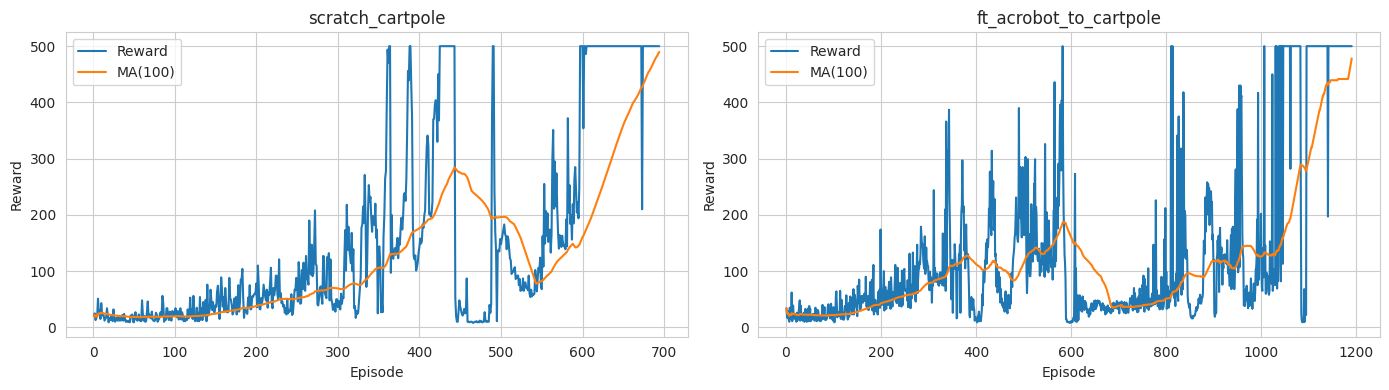

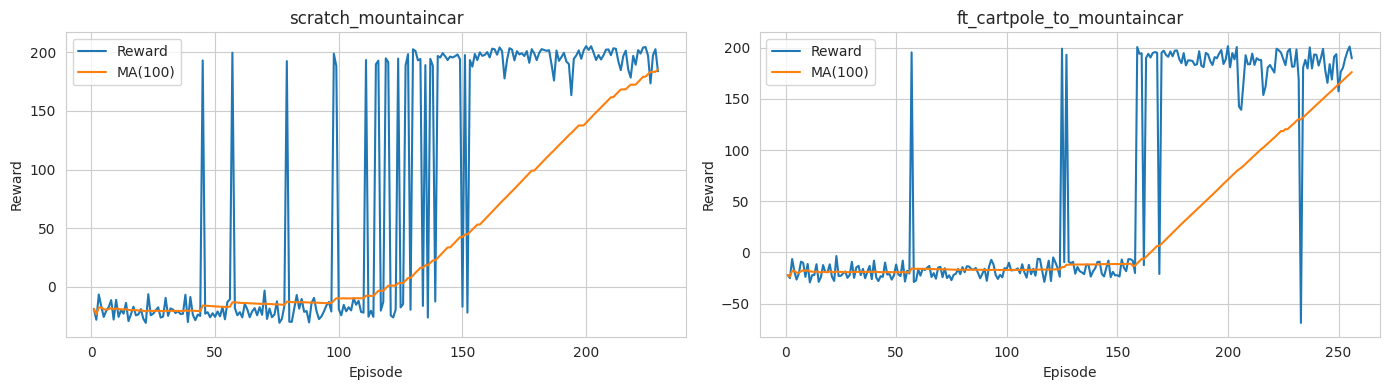

In [11]:
baseline_summaries = {
    "cartpole": summarize_run(histories["cartpole"]),
    "acrobot": summarize_run(histories["acrobot"]),
    "mountaincar": summarize_run(histories["mountaincar"]),
}

# Pair 1: acrobot -> cartpole compares to cartpole scratch
print(compare_runs(baseline_summaries["cartpole"], finetune_summaries["acrobot_to_cartpole"]))

# Pair 2: cartpole -> mountaincar compares to mountaincar scratch
print(compare_runs(baseline_summaries["mountaincar"], finetune_summaries["cartpole_to_mountaincar"]))

plot_training_curves_grid(
    {
        "scratch_cartpole": histories["cartpole"],
        "ft_acrobot_to_cartpole": finetune_histories["acrobot_to_cartpole"],
    },
    order=["scratch_cartpole", "ft_acrobot_to_cartpole"],
    grid_shape=(1, 2),
    figsize=(14, 4),
)

plot_training_curves_grid(
    {
        "scratch_mountaincar": histories["mountaincar"],
        "ft_cartpole_to_mountaincar": finetune_histories["cartpole_to_mountaincar"],
    },
    order=["scratch_mountaincar", "ft_cartpole_to_mountaincar"],
    grid_shape=(1, 2),
    figsize=(14, 4),
)

### Re-Initiating only Actor's Output

In [12]:
# finetune_histories = {}
# finetune_summaries = {}

# for exp in FT_EXPERIMENTS:
#     print("\n" + "="*90)
#     print(f"Fine-tuning: {exp['name']}  |  target={exp['gym_id']}")
#     print("="*90)

#     # Create target env in notebook (clean ownership)
#     env = gym.make(exp["gym_id"])
#     env.reset(seed=SEED)
#     env.action_space.seed(SEED)

#     if exp["gym_id"] == "MountainCarContinuous-v0":
#         env = MountainCarRewardShaping(env, position_weight=10.0, velocity_weight=1.0)
#         print("✓ Reward shaping applied for MountainCar")
        
#     hist = finetune_actor_critic(
#         source_ckpt_path=exp["source_ckpt"],
#         target_env=env,
#         target_env_spec=specs[exp["target_key"]],
#         seed=SEED,
#         max_episodes=exp["max_episodes"],
#         max_steps_per_episode=exp["max_steps"],
#         ma_window=exp["ma_window"],
#         target_success_rate=exp["target_success_rate"],
#         success_criterion=exp["success_criterion"],
#         agent_cfg=exp["agent_cfg"],
#         verbose=True,
#         print_every=50,
#         reset_seed_base=SEED,
#         save_path=exp["save_path"],
#         reinit_actor_head=True,
#         reinit_critic_head=False,
#     )

#     env.close()

#     finetune_histories[exp["name"]] = hist
#     finetune_summaries[exp["name"]] = summarize_run(hist)

#     print("Summary:", finetune_summaries[exp["name"]])

In [13]:
# baseline_summaries = {
#     "cartpole": summarize_run(histories["cartpole"]),
#     "acrobot": summarize_run(histories["acrobot"]),
#     "mountaincar": summarize_run(histories["mountaincar"]),
# }

# # Pair 1: acrobot -> cartpole compares to cartpole scratch
# print(compare_runs(baseline_summaries["cartpole"], finetune_summaries["acrobot_to_cartpole"]))

# # Pair 2: cartpole -> mountaincar compares to mountaincar scratch
# print(compare_runs(baseline_summaries["mountaincar"], finetune_summaries["cartpole_to_mountaincar"]))

# plot_training_curves_grid(
#     {
#         "scratch_cartpole": histories["cartpole"],
#         "ft_acrobot_to_cartpole": finetune_histories["acrobot_to_cartpole"],
#     },
#     order=["scratch_cartpole", "ft_acrobot_to_cartpole"],
#     grid_shape=(1, 2),
#     figsize=(14, 4),
# )

# plot_training_curves_grid(
#     {
#         "scratch_mountaincar": histories["mountaincar"],
#         "ft_cartpole_to_mountaincar": finetune_histories["cartpole_to_mountaincar"],
#     },
#     order=["scratch_mountaincar", "ft_cartpole_to_mountaincar"],
#     grid_shape=(1, 2),
#     figsize=(14, 4),
# )

## Part 3: Transfer Learning with Progressive Networks

In this part, we implement Progressive Neural Networks for transfer learning. Unlike fine-tuning (Part 2), Progressive Networks:

1. **Freeze** all source model parameters - they never update during training
2. **Extract features** from all source models' hidden layers
3. **Concatenate** source features with target features (lateral connections)
4. **Train** only the target model's trunk and new output heads

This approach allows leveraging knowledge from multiple pre-trained models while avoiding catastrophic forgetting.

### Architecture Overview:
```
Input State (x)
    │
    ├──► Source 1 Hidden (frozen) ──► h₁
    ├──► Source 2 Hidden (frozen) ──► h₂
    └──► Target Hidden (trainable) ─► h_target
                                        │
                    ┌───────────────────┴───────────────────┐
                    │  Concatenate: [h_target, h₁, h₂, ...]  │
                    └───────────────────┬───────────────────┘
                                        │
                            ┌───────────┴───────────┐
                            │                       │
                    Actor Head (new)         Critic Head (new)
                            │                       │
                      π(a|s) logits              V(s)
```

In [14]:
# Import and reload the progressive module
import src.progressive
importlib.reload(src.progressive)
from src.progressive import ProgressiveActorCritic, ProgressiveActorCriticAgent

print("✓ Progressive Networks module loaded")

✓ Progressive Networks module loaded


In [15]:
# Configuration for Progressive Networks experiments
SEED = 42
STATE_DIM = 6
ACTION_DIM = 5

specs = get_default_env_specs(state_dim=STATE_DIM, action_dim=ACTION_DIM)

# Paths to pre-trained source models
CKPTS = {
    "cartpole": "models/CartPole-v1.pth",
    "acrobot": "models/Acrobot-v1.pth",
    "mountaincar": "models/MountainCarContinuous-v0.pth",
}

# Progressive Networks Experiments
PROGRESSIVE_EXPERIMENTS = [
    {
        "name": "progressive_cartpole",
        "description": "Target=CartPole | Sources=[Acrobot, MountainCar]",
        "target_key": "cartpole",
        "source_keys": ["acrobot", "mountaincar"],
        "gym_id": "CartPole-v1",
        "max_episodes": 2000,
        "max_steps": 500,
        "ma_window": MA_WINDOW,
        "target_success_rate": 0.95,
        "success_criterion": {"type": "length", "threshold": 500, "comparison": "greater_equal"},
        "agent_cfg": BASE_AGENT_CFG,
        "save_path": "models/progressive_cartpole.pth",
    },
    {
        "name": "progressive_mountaincar",
        "description": "Target=MountainCar | Sources=[CartPole, Acrobot]",
        "target_key": "mountaincar",
        "source_keys": ["cartpole", "acrobot"],
        "gym_id": "MountainCarContinuous-v0",
        "max_episodes": 10000,
        "max_steps": 999,
        "ma_window": MA_WINDOW,
        "target_success_rate": 0.95,
        "success_criterion": {"type": "length", "threshold": 999, "comparison": "less"},
        "agent_cfg": AgentConfig(**{**asdict(BASE_AGENT_CFG), "entropy_coef": 0.10}),
        "save_path": "models/progressive_mountaincar.pth",
    },
]

print("✓ Progressive experiments configured")
for exp in PROGRESSIVE_EXPERIMENTS:
    print(f"  • {exp['name']}: {exp['description']}")

✓ Progressive experiments configured
  • progressive_cartpole: Target=CartPole | Sources=[Acrobot, MountainCar]
  • progressive_mountaincar: Target=MountainCar | Sources=[CartPole, Acrobot]


### Scenario A: Target = CartPole | Sources = [Acrobot, MountainCar]

Training CartPole using knowledge from both Acrobot and MountainCar source models.

In [16]:
progressive_histories = {}
progressive_summaries = {}

# Experiment: CartPole with Acrobot + MountainCar sources
exp = PROGRESSIVE_EXPERIMENTS[0]  # progressive_cartpole

print("\n" + "="*90)
print(f"Progressive Transfer: {exp['description']}")
print("="*90)

# 1) Load source agents (frozen)
source_agents = []
for src_key in exp["source_keys"]:
    src_agent = ActorCriticAgent.load_model(CKPTS[src_key])
    source_agents.append(src_agent)
    print(f"  Loaded source: {src_key}")

# 2) Create target environment
env = gym.make(exp["gym_id"])
env.reset(seed=SEED)
env.action_space.seed(SEED)

# 3) Create Progressive Agent
progressive_agent = ProgressiveActorCriticAgent(
    env_spec=specs[exp["target_key"]],
    source_agents=source_agents,
    config=exp["agent_cfg"],
    seed=SEED,
)

# 4) Train using the standard training loop
hist = train_actor_critic(
    env=env,
    agent=progressive_agent,
    max_episodes=exp["max_episodes"],
    max_steps_per_episode=exp["max_steps"],
    ma_window=exp["ma_window"],
    target_success_rate=exp["target_success_rate"],
    success_criterion=exp["success_criterion"],
    verbose=True,
    print_every=50,
    reset_seed_base=SEED,
    save_path=exp["save_path"],
)

env.close()

progressive_histories[exp["name"]] = hist
progressive_summaries[exp["name"]] = summarize_run(hist)

print("\n" + "-"*50)
print(f"Results for {exp['name']}:")
print(f"  Converged: {hist['converged']}")
print(f"  Episodes trained: {hist['episodes_trained']}")
print(f"  Time elapsed: {hist['seconds_elapsed']:.2f} seconds")
print("-"*50)


Progressive Transfer: Target=CartPole | Sources=[Acrobot, MountainCar]
✓ Agent device: cuda
✓ Model loaded from models/Acrobot-v1.pth
  Loaded source: acrobot
✓ Agent device: cuda
✓ Model loaded from models/MountainCarContinuous-v0.pth
  Loaded source: mountaincar
✓ Progressive Agent device: cuda
✓ Agent device: cuda
✓ Source model 1 (acrobot) frozen
✓ Source model 2 (mountaincar) frozen
✓ Progressive network initialized with 2 source(s)
  Target hidden dim: 128
  Total fused dim: 384
✓ Progressive Agent initialized
  Trainable actor params: 2821
  Trainable critic params: 1281
[cartpole] ep=   1 MA_R(100)=   14.00 MA_len(100)=  14.0 success_rate=0.00%
[cartpole] ep=  50 MA_R(100)=   11.24 MA_len(100)=  11.2 success_rate=0.00%
[cartpole] ep= 100 MA_R(100)=   10.99 MA_len(100)=  11.0 success_rate=0.00%
[cartpole] ep= 150 MA_R(100)=   21.09 MA_len(100)=  21.1 success_rate=0.00%
[cartpole] ep= 200 MA_R(100)=   37.59 MA_len(100)=  37.6 success_rate=0.00%
[cartpole] ep= 250 MA_R(100)=   41

### Scenario B: Target = MountainCar | Sources = [CartPole, Acrobot]

Training MountainCar using knowledge from both CartPole and Acrobot source models.

In [17]:
# Experiment: MountainCar with CartPole + Acrobot sources
exp = PROGRESSIVE_EXPERIMENTS[1]  # progressive_mountaincar

print("\n" + "="*90)
print(f"Progressive Transfer: {exp['description']}")
print("="*90)

# 1) Load source agents (frozen)
source_agents = []
for src_key in exp["source_keys"]:
    src_agent = ActorCriticAgent.load_model(CKPTS[src_key])
    source_agents.append(src_agent)
    print(f"  Loaded source: {src_key}")

# 2) Create target environment with reward shaping
env = gym.make(exp["gym_id"])
env = MountainCarRewardShaping(env, position_weight=10.0, velocity_weight=1.0)
print("✓ Reward shaping applied for MountainCar")
env.reset(seed=SEED)
env.action_space.seed(SEED)

# 3) Create Progressive Agent
progressive_agent = ProgressiveActorCriticAgent(
    env_spec=specs[exp["target_key"]],
    source_agents=source_agents,
    config=exp["agent_cfg"],
    seed=SEED,
)

# 4) Train using the standard training loop
hist = train_actor_critic(
    env=env,
    agent=progressive_agent,
    max_episodes=exp["max_episodes"],
    max_steps_per_episode=exp["max_steps"],
    ma_window=exp["ma_window"],
    target_success_rate=exp["target_success_rate"],
    success_criterion=exp["success_criterion"],
    verbose=True,
    print_every=50,
    reset_seed_base=SEED,
    save_path=exp["save_path"],
)

env.close()

progressive_histories[exp["name"]] = hist
progressive_summaries[exp["name"]] = summarize_run(hist)

print("\n" + "-"*50)
print(f"Results for {exp['name']}:")
print(f"  Converged: {hist['converged']}")
print(f"  Episodes trained: {hist['episodes_trained']}")
print(f"  Time elapsed: {hist['seconds_elapsed']:.2f} seconds")
print("-"*50)


Progressive Transfer: Target=MountainCar | Sources=[CartPole, Acrobot]
✓ Agent device: cuda
✓ Model loaded from models/CartPole-v1.pth
  Loaded source: cartpole
✓ Agent device: cuda
✓ Model loaded from models/Acrobot-v1.pth
  Loaded source: acrobot
✓ Reward shaping applied for MountainCar
✓ Progressive Agent device: cuda
✓ Agent device: cuda
✓ Source model 1 (cartpole) frozen
✓ Source model 2 (acrobot) frozen
✓ Progressive network initialized with 2 source(s)
  Target hidden dim: 128
  Total fused dim: 384
✓ Progressive Agent initialized
  Trainable actor params: 2821
  Trainable critic params: 1281
[mountaincar] ep=   1 MA_R(100)=  -23.15 MA_len(100)= 999.0 success_rate=0.00%
[mountaincar] ep=  50 MA_R(100)=  -19.26 MA_len(100)= 999.0 success_rate=0.00%
[mountaincar] ep= 100 MA_R(100)=  -17.24 MA_len(100)= 998.0 success_rate=1.00%
[mountaincar] ep= 150 MA_R(100)=  -13.43 MA_len(100)= 994.4 success_rate=3.00%
[mountaincar] ep= 200 MA_R(100)=   -9.55 MA_len(100)= 988.5 success_rate=5.0

### Results Analysis: Progressive Networks vs Scratch Training

Compare the performance of Progressive Networks against training from scratch.

In [18]:
# Summary comparison table
print("\n" + "="*90)
print("PROGRESSIVE NETWORKS - RESULTS SUMMARY")
print("="*90)

# Get baseline summaries (from Part 1 training)
baseline_summaries = {
    "cartpole": summarize_run(histories["cartpole"]),
    "mountaincar": summarize_run(histories["mountaincar"]),
}

# Print comparison table
print("\n┌─────────────────────────────────────────────────────────────────────────────────────┐")
print("│                         CONVERGENCE COMPARISON                                      │")
print("├───────────────────────┬────────────────┬────────────────┬───────────────────────────┤")
print("│ Experiment            │ Episodes       │ Time (s)       │ Converged                 │")
print("├───────────────────────┼────────────────┼────────────────┼───────────────────────────┤")

# CartPole comparison
cp_scratch = histories["cartpole"]
cp_prog = progressive_histories["progressive_cartpole"]
print(f"│ CartPole (scratch)    │ {cp_scratch['episodes_trained']:>14} │ {cp_scratch['seconds_elapsed']:>14.2f} │ {str(cp_scratch['converged']):>25} │")
print(f"│ CartPole (progressive)│ {cp_prog['episodes_trained']:>14} │ {cp_prog['seconds_elapsed']:>14.2f} │ {str(cp_prog['converged']):>25} │")

# MountainCar comparison
mc_scratch = histories["mountaincar"]
mc_prog = progressive_histories["progressive_mountaincar"]
print(f"│ MountainCar (scratch) │ {mc_scratch['episodes_trained']:>14} │ {mc_scratch['seconds_elapsed']:>14.2f} │ {str(mc_scratch['converged']):>25} │")
print(f"│ MountainCar (prog.)   │ {mc_prog['episodes_trained']:>14} │ {mc_prog['seconds_elapsed']:>14.2f} │ {str(mc_prog['converged']):>25} │")

print("└───────────────────────┴────────────────┴────────────────┴───────────────────────────┘")

# Speedup calculations
print("\n--- Speedup Analysis ---")
if cp_scratch['converged'] and cp_prog['converged']:
    cp_speedup_ep = cp_scratch['episodes_trained'] / cp_prog['episodes_trained']
    cp_speedup_time = cp_scratch['seconds_elapsed'] / cp_prog['seconds_elapsed']
    print(f"CartPole Progressive vs Scratch:")
    print(f"  Episode speedup: {cp_speedup_ep:.2f}x ({cp_scratch['episodes_trained']} → {cp_prog['episodes_trained']} episodes)")
    print(f"  Time speedup: {cp_speedup_time:.2f}x ({cp_scratch['seconds_elapsed']:.1f}s → {cp_prog['seconds_elapsed']:.1f}s)")

if mc_scratch['converged'] and mc_prog['converged']:
    mc_speedup_ep = mc_scratch['episodes_trained'] / mc_prog['episodes_trained']
    mc_speedup_time = mc_scratch['seconds_elapsed'] / mc_prog['seconds_elapsed']
    print(f"\nMountainCar Progressive vs Scratch:")
    print(f"  Episode speedup: {mc_speedup_ep:.2f}x ({mc_scratch['episodes_trained']} → {mc_prog['episodes_trained']} episodes)")
    print(f"  Time speedup: {mc_speedup_time:.2f}x ({mc_scratch['seconds_elapsed']:.1f}s → {mc_prog['seconds_elapsed']:.1f}s)")


PROGRESSIVE NETWORKS - RESULTS SUMMARY

┌─────────────────────────────────────────────────────────────────────────────────────┐
│                         CONVERGENCE COMPARISON                                      │
├───────────────────────┬────────────────┬────────────────┬───────────────────────────┤
│ Experiment            │ Episodes       │ Time (s)       │ Converged                 │
├───────────────────────┼────────────────┼────────────────┼───────────────────────────┤
│ CartPole (scratch)    │            694 │         335.48 │                      True │
│ CartPole (progressive)│            993 │         444.53 │                      True │
│ MountainCar (scratch) │            229 │         511.44 │                      True │
│ MountainCar (prog.)   │            436 │        1390.95 │                      True │
└───────────────────────┴────────────────┴────────────────┴───────────────────────────┘

--- Speedup Analysis ---
CartPole Progressive vs Scratch:
  Episode speedup: 0

✓ Figure saved to results/part3_cartpole_plots.png


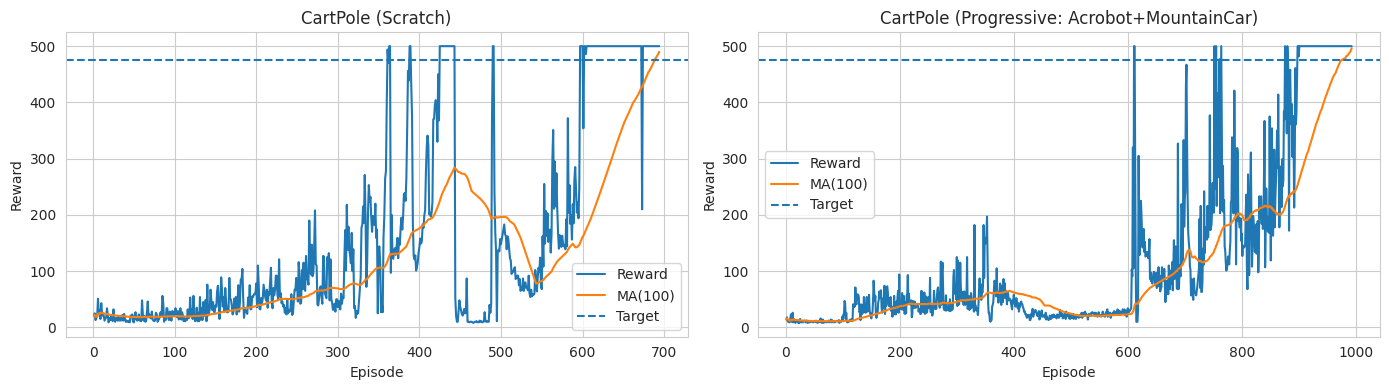

✓ Figure saved to results/part3_mountaincar_plots.png


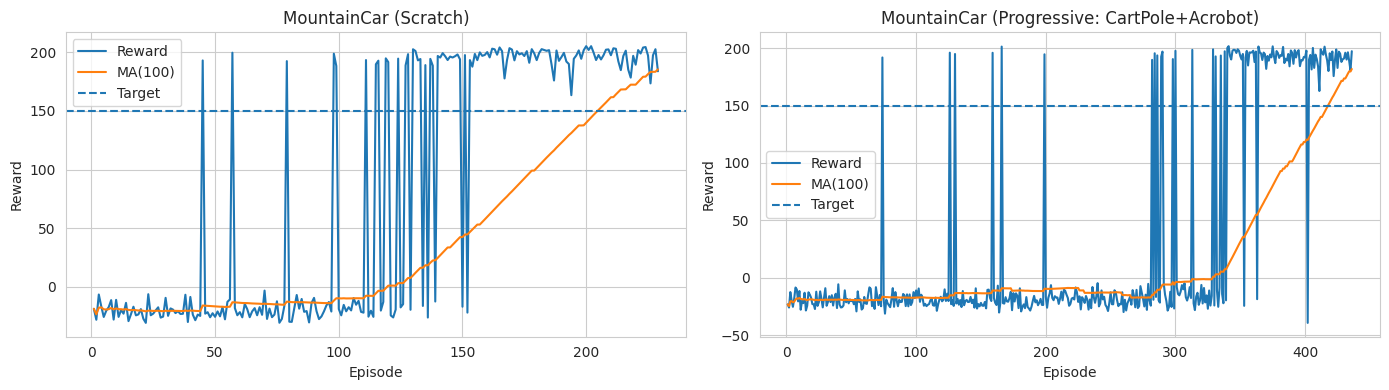

In [19]:
# Visualize training curves: Progressive vs Scratch

# CartPole comparison
plot_training_curves_grid(
    {
        "scratch_cartpole": histories["cartpole"],
        "progressive_cartpole": progressive_histories["progressive_cartpole"],
    },
    order=["scratch_cartpole", "progressive_cartpole"],
    titles={
        "scratch_cartpole": "CartPole (Scratch)",
        "progressive_cartpole": "CartPole (Progressive: Acrobot+MountainCar)",
    },
    thresholds={"scratch_cartpole": 475, "progressive_cartpole": 475},
    grid_shape=(1, 2),
    figsize=(14, 4),
    save_path="results/part3_cartpole_plots.png",
)

# MountainCar comparison
plot_training_curves_grid(
    {
        "scratch_mountaincar": histories["mountaincar"],
        "progressive_mountaincar": progressive_histories["progressive_mountaincar"],
    },
    order=["scratch_mountaincar", "progressive_mountaincar"],
    titles={
        "scratch_mountaincar": "MountainCar (Scratch)",
        "progressive_mountaincar": "MountainCar (Progressive: CartPole+Acrobot)",
    },
    thresholds={"scratch_mountaincar": 150, "progressive_mountaincar": 150},
    grid_shape=(1, 2),
    figsize=(14, 4),
    save_path="results/part3_mountaincar_plots.png",
)

✓ Figure saved to results/part3_diagnostics.png


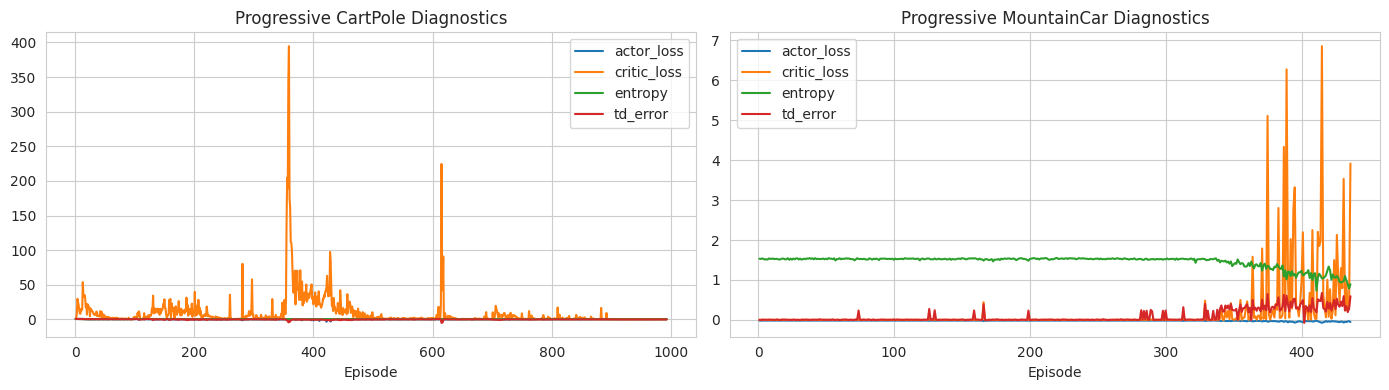

In [20]:
# Diagnostics for progressive training runs
plot_diagnostics_grid(
    progressive_histories,
    order=["progressive_cartpole", "progressive_mountaincar"],
    titles={
        "progressive_cartpole": "Progressive CartPole Diagnostics",
        "progressive_mountaincar": "Progressive MountainCar Diagnostics",
    },
    grid_shape=(1, 2),
    figsize=(14, 4),
    save_path="results/part3_diagnostics.png",
)